In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import re
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from rfpimp import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [4]:
# counts of missing values
df.isnull().sum().sort_values(ascending=False)

region_2                 79460
designation              37465
taster_twitter_handle    31213
taster_name              26244
region_1                 21247
price                     8996
province                    63
country                     63
variety                      1
winery                       0
title                        0
points                       0
description                  0
dtype: int64

In [5]:
# percentages of missing values
df.isnull().sum().sort_values(ascending=False)/len(df)

region_2                 0.611367
designation              0.288257
taster_twitter_handle    0.240154
taster_name              0.201922
region_1                 0.163475
price                    0.069215
province                 0.000485
country                  0.000485
variety                  0.000008
winery                   0.000000
title                    0.000000
points                   0.000000
description              0.000000
dtype: float64

In [6]:
df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [7]:
# correlation between the two numeric columns, points (score) and price
df.corr()

,points,price
points,1.000000,0.416167
price,0.416167,1.000000


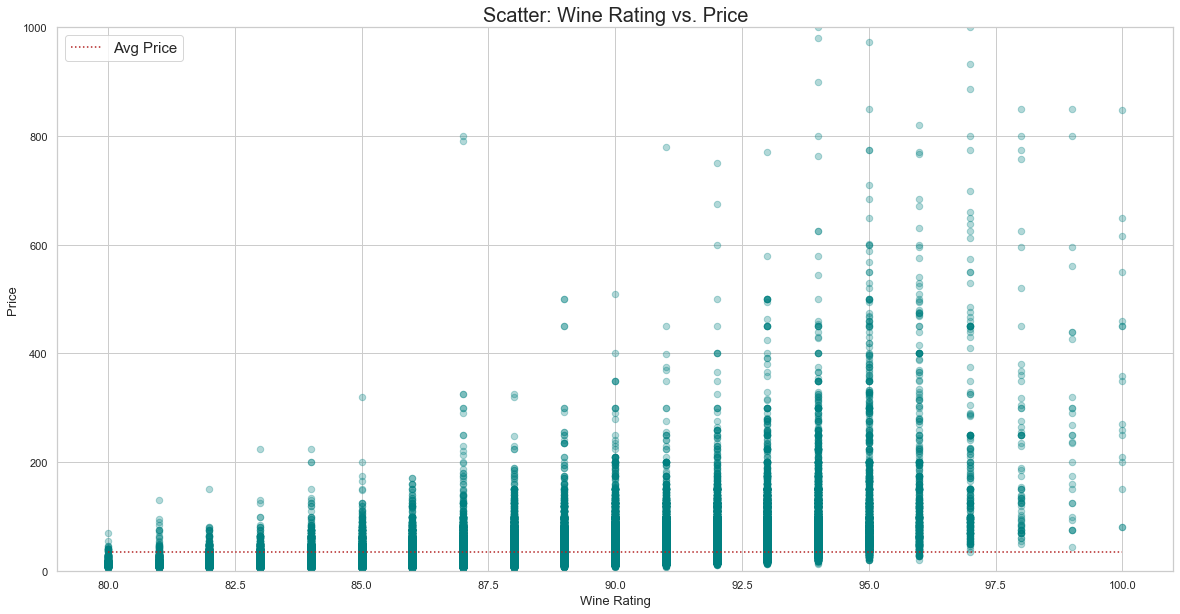

In [8]:
# scatterplot
fig = plt.figure(figsize=(20,10))
plt.scatter(df.points, df.price, alpha=.3, s=42, c='teal',)
plt.ylim((0, 1000))
plt.hlines(35.3, xmin=80, xmax=100, linestyles='dotted', colors='firebrick', label='Avg Price')
plt.title('Scatter: Wine Rating vs. Price', size=20)
plt.xlabel('Wine Rating', size=13)
plt.ylabel('Price', size=13)
plt.legend(loc = 2, fontsize=15)
plt.show()

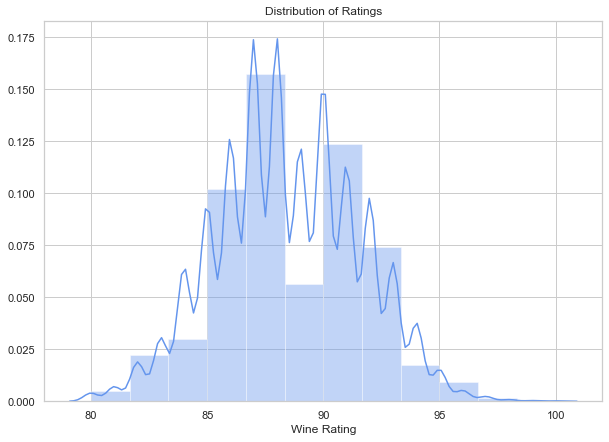

In [9]:
fig = plt.figure(figsize=(10,7))
sns.distplot(df.points, bins=12, color='cornflowerblue')
plt.title('Distribution of Ratings')
plt.xlabel('Wine Rating')
plt.show()

In [10]:
# countries with more than 100 wine ratings 
country_cts = df.groupby('country')['description'].count()
country_many_reviews = country_cts[country_cts > 100].index
country_many_reviews

Index(['Argentina', 'Australia', 'Austria', 'Bulgaria', 'Canada', 'Chile',
       'France', 'Germany', 'Greece', 'Hungary', 'Israel', 'Italy',
       'New Zealand', 'Portugal', 'Romania', 'South Africa', 'Spain', 'US',
       'Uruguay'],
      dtype='object', name='country')

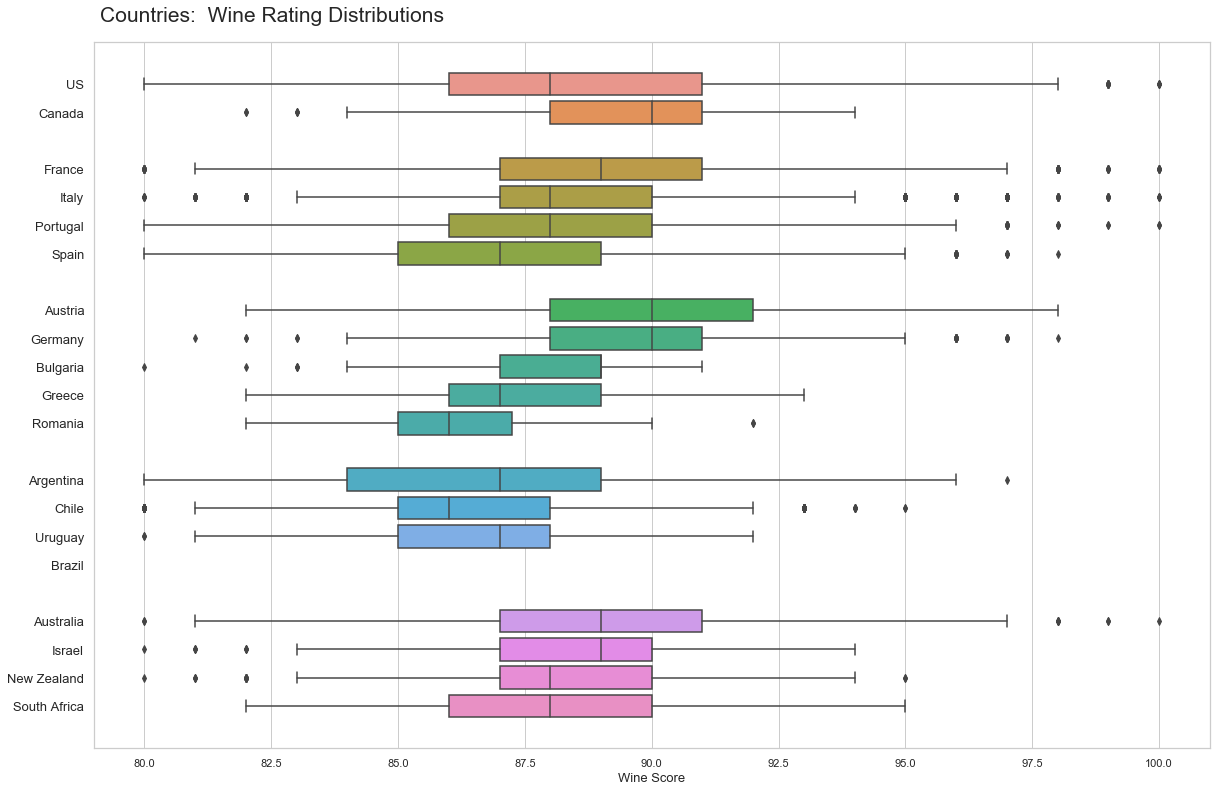

In [11]:
plt.figure(figsize=(20,13))

# data=df[df.country.isin(country_many_reviews)

sns.boxplot(x="points", y="country", data=df[df.country.isin(country_many_reviews)],
           order=['','US','Canada',
                  '','France','Italy','Portugal','Spain',
                  '','Austria','Germany','Bulgaria','Greece','Romania',
                  '','Argentina','Chile','Uruguay','Brazil',
                  '','Australia','Israel','New Zealand','South Africa',''])
                  

plt.title('Countries:  Wine Rating Distributions', x=.16, y=1.02, fontsize=21)

plt.xlabel('Wine Score', size=13)
plt.ylabel('', size=13)
plt.yticks(fontsize=13)
plt.show()

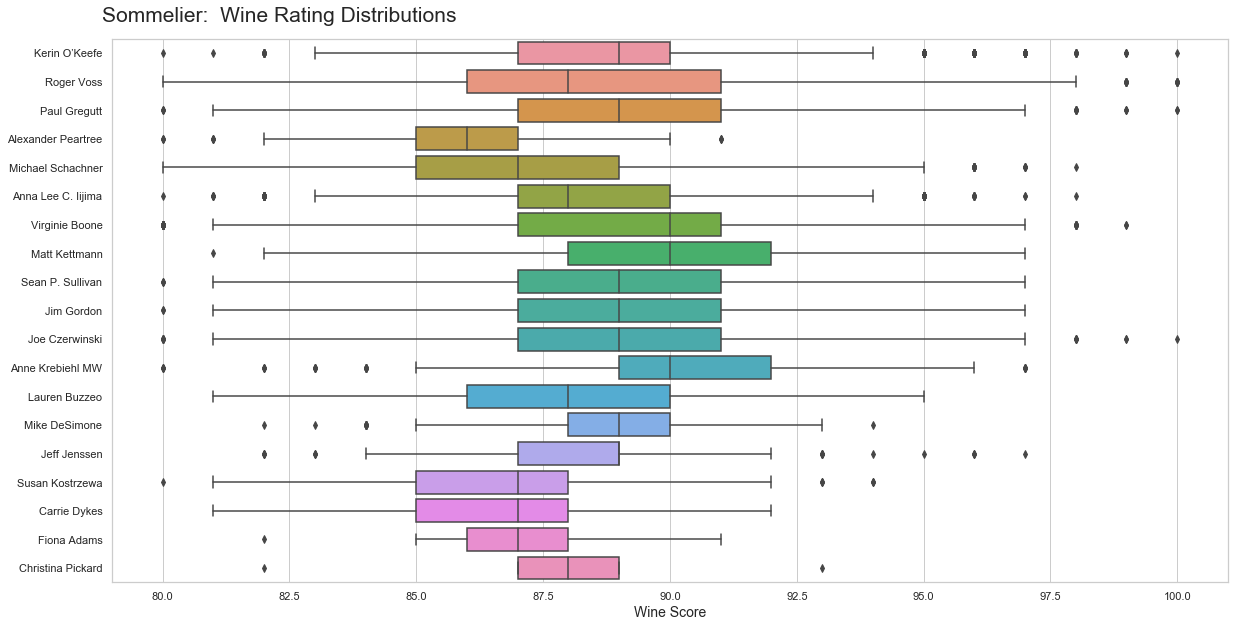

In [12]:
plt.figure(figsize=(20,10))
sns.boxplot(x="points", y="taster_name", data=df)

plt.title('Sommelier:  Wine Rating Distributions', x=.15, y=1.02, fontsize=21)

plt.xlabel('Wine Score', size=14)
plt.ylabel('', size=13)
plt.show()

In [13]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [14]:
province_gb = df.groupby('province')['points'].aggregate({"points": ["mean", "median", "count"]})
province_gb.columns = ['_'.join(col).strip() for col in province_gb.columns]
province_many_reviews = province_gb[province_gb.points_count > 65].reset_index()
province_many_reviews

,province,points_mean,points_median,points_count
0,Aconcagua Valley,88.163793,88.0,116
1,Alentejano,87.905016,88.0,937
2,Alentejo,88.653846,88.0,182
3,Alsace,89.372131,89.0,2440
4,America,86.505263,86.0,95
...,...,...,...,...
95,Washington,88.947216,89.0,8639
96,Weinviertel,89.560000,90.0,100
97,Western Australia,88.912587,89.0,286
98,Western Cape,86.733096,87.0,281


In [15]:
co_province_gb = df.groupby(['country','province'])['points'].aggregate({"points": ["mean", "median", "count"]})
co_province_gb.columns = ['_'.join(col).strip() for col in co_province_gb.columns]
co_province_many_reviews = co_province_gb[co_province_gb.points_count > 500].reset_index()
co_province_many_reviews

,country,province,points_mean,points_median,points_count
0,Argentina,Mendoza Province,86.826593,87.0,3264
1,Argentina,Other,86.001866,86.0,536
2,Australia,South Australia,89.037806,89.0,1349
3,Austria,Burgenland,89.619048,90.0,672
4,Austria,Niederösterreich,88.936667,89.0,600
5,Chile,Casablanca Valley,86.237937,86.0,601
6,Chile,Colchagua Valley,87.098795,87.0,830
7,Chile,Maipo Valley,86.825493,87.0,659
8,France,Alsace,89.372131,89.0,2440
9,France,Beaujolais,87.954981,88.0,1044


In [16]:
# To Implement:
# First Linear Base Models
# Regularization variations
# See what features are dropped
# Examine B's

# Metrics > Switch to Median Absolute Error

# Run Basic Version Before Heavy Feature Engineering

In [17]:
# price is the only numeric column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 18.9+ MB


In [18]:
price = df['price']
price = price.fillna(price.median()).to_numpy().reshape(-1,1)

X_baseline = price
y = df['points'].to_numpy().reshape(-1,1)

In [19]:
X_train_b, X_test_b, y_train, y_test = train_test_split(X_baseline, y, test_size=0.20, random_state=42)

In [20]:
def evaluate(y_test, y_pred):

    results = {'Median AE' : round(median_absolute_error(y_test, y_pred), 3),
               'MeanAE' : round(mean_absolute_error(y_test, y_pred), 3),
               'R-Sq' : round(r2_score(y_test, y_pred), 2),
               'MSE' : round(mean_squared_error(y_test, y_pred),2),
               'Max Error': round(max_error(y_test, y_pred),2)}
                             
    return results

In [21]:
%%time
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_b, y_train)
y_pred_b = lr.predict(X_test_b)
lr_results_b = evaluate(y_test, y_pred_b)

CPU times: user 14.8 ms, sys: 2.19 ms, total: 17 ms
Wall time: 13 ms


In [22]:
lr_results_b

{'Median AE': 1.9,
 'MeanAE': 2.229,
 'R-Sq': 0.15,
 'MSE': 7.94,
 'Max Error': 58.63}

In [23]:
%%time
lasso = Lasso()
lasso.fit(X_train_b, y_train)
y_pred_lasso = lasso.predict(X_test_b)
lasso_results_b = evaluate(y_test, y_pred_lasso)

CPU times: user 11.4 ms, sys: 1.2 ms, total: 12.6 ms
Wall time: 16.5 ms


In [24]:
lasso_results_b

{'Median AE': 1.91,
 'MeanAE': 2.232,
 'R-Sq': 0.15,
 'MSE': 7.94,
 'Max Error': 57.35}

In [25]:
%%time
sgd = SGDRegressor()
sgd.fit(X_train_b, y_train)
y_pred_sgd = sgd.predict(X_test_b)
sgd_results_b = evaluate(y_test, y_pred_sgd)

CPU times: user 349 ms, sys: 5.16 ms, total: 355 ms
Wall time: 370 ms


In [26]:
sgd_results_b

{'Median AE': 3.499,
 'MeanAE': 5.102,
 'R-Sq': -7.86,
 'MSE': 83.03,
 'Max Error': 350.27}

In [27]:
%%time
rf = RandomForestRegressor(n_estimators=100,
                           min_samples_leaf=5,
                           n_jobs=-1)
rf.fit(X_train_b, y_train)
y_pred_rf = rf.predict(X_test_b)
rf_results_b = evaluate(y_test, y_pred_rf)

CPU times: user 4.85 s, sys: 73.4 ms, total: 4.92 s
Wall time: 1.81 s


In [28]:
rf_results_b

{'Median AE': 1.622,
 'MeanAE': 1.954,
 'R-Sq': 0.36,
 'MSE': 6.04,
 'Max Error': 10.85}

In [29]:
%%time
gbr = GradientBoostingRegressor(n_estimators=100,
                                min_samples_leaf=5)
gbr.fit(X_train_b, y_train)
y_pred_gbr = gbr.predict(X_test_b)
gbr_results_b = evaluate(y_test, y_pred_gbr)

CPU times: user 4.05 s, sys: 56.2 ms, total: 4.11 s
Wall time: 2.39 s


In [30]:
gbr_results_b

{'Median AE': 1.608,
 'MeanAE': 1.953,
 'R-Sq': 0.36,
 'MSE': 6.03,
 'Max Error': 10.8}

# One Hot Encoding

In [31]:
hot_tasters = pd.get_dummies(df['taster_name'])
hot_countries = pd.get_dummies(df['country']) 
hot_regions = pd.get_dummies(df['region_2'])

In [32]:
hot_tasters.head(3)

,Alexander Peartree,Anna Lee C. Iijima,Anne Krebiehl MW,Carrie Dykes,Christina Pickard,Fiona Adams,Jeff Jenssen,Jim Gordon,Joe Czerwinski,Kerin O’Keefe,Lauren Buzzeo,Matt Kettmann,Michael Schachner,Mike DeSimone,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [33]:
hot_tasters.corrwith(df['points']).abs().sort_values(ascending=False)

Michael Schachner     0.183875
Anne Krebiehl MW      0.118878
Matt Kettmann         0.116256
Virginie Boone        0.070935
Paul Gregutt          0.058808
Susan Kostrzewa       0.055476
Alexander Peartree    0.048256
Roger Voss            0.042413
Kerin O’Keefe         0.041625
Lauren Buzzeo         0.027858
Carrie Dykes          0.022082
Sean P. Sullivan      0.020235
Mike DeSimone         0.013558
Jim Gordon            0.010739
Fiona Adams           0.007389
Joe Czerwinski        0.005952
Jeff Jenssen          0.002581
Anna Lee C. Iijima    0.001944
Christina Pickard     0.001372
dtype: float64

In [34]:
hot_countries.head(3)

,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,Brazil,Bulgaria,Canada,Chile,China,...,Serbia,Slovakia,Slovenia,South Africa,Spain,Switzerland,Turkey,US,Ukraine,Uruguay
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
hot_countries.corrwith(df['points']).abs().sort_values(ascending=False)[:15]

Chile        0.121322
Argentina    0.099162
Spain        0.088490
Austria      0.088449
Germany      0.060141
France       0.059249
US           0.032594
Brazil       0.024839
England      0.024608
Mexico       0.024361
Greece       0.022968
Romania      0.020473
Peru         0.017830
Uruguay      0.016154
Italy        0.015927
dtype: float64

In [36]:
hot_regions.head(3)

,California Other,Central Coast,Central Valley,Columbia Valley,Finger Lakes,Long Island,Napa,Napa-Sonoma,New York Other,North Coast,Oregon Other,Sierra Foothills,Sonoma,South Coast,Southern Oregon,Washington Other,Willamette Valley
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
hot_regions.corrwith(df['points']).abs().sort_values(ascending=False)

California Other     0.130871
Napa                 0.073114
Willamette Valley    0.054792
Finger Lakes         0.051082
Columbia Valley      0.046187
Central Valley       0.045376
Sonoma               0.043649
Central Coast        0.037960
Southern Oregon      0.027883
New York Other       0.027840
Long Island          0.021158
Napa-Sonoma          0.010893
North Coast          0.010375
South Coast          0.009284
Sierra Foothills     0.006377
Washington Other     0.003711
Oregon Other         0.003324
dtype: float64

In [38]:
z_price = StandardScaler().fit_transform(price)
z_price = pd.DataFrame({'Z Price' : z_price.flatten()})
z_price

,Z Price
0,-0.243193
1,-0.495310
2,-0.520521
3,-0.545733
4,0.765272
...,...
129966,-0.167559
129967,1.017388
129968,-0.117135
129969,-0.066712


In [39]:
X_encoded = pd.concat([z_price, hot_regions, hot_countries, hot_tasters], axis=1)
y = df["points"]

In [40]:
X_encoded

,Z Price,California Other,Central Coast,Central Valley,Columbia Valley,Finger Lakes,Long Island,Napa,Napa-Sonoma,New York Other,...,Kerin O’Keefe,Lauren Buzzeo,Matt Kettmann,Michael Schachner,Mike DeSimone,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone
0,-0.243193,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.495310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.520521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.545733,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.765272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,-0.167559,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129967,1.017388,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
129968,-0.117135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
129969,-0.066712,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42)

In [42]:
lr.fit(X_train_encoded, y_train)
y_pred_encoded = lr.predict(X_test_encoded)
lr_results_encoded = evaluate(y_test, y_pred_encoded)

In [43]:
lr_results_encoded

{'Median AE': 1.791,
 'MeanAE': 2.087,
 'R-Sq': 0.25,
 'MSE': 6.99,
 'Max Error': 54.72}

In [44]:
lasso.fit(X_train_encoded, y_train)
y_pred_encoded_lasso = lasso.predict(X_test_encoded)
lasso_results_encoded = evaluate(y_test, y_pred_encoded_lasso)

In [45]:
lasso_results_encoded

{'Median AE': 2.329,
 'MeanAE': 2.44,
 'R-Sq': 0.05,
 'MSE': 8.9,
 'Max Error': 11.31}

In [46]:
%%time
rf.fit(X_train_encoded, y_train)
y_pred_rf = rf.predict(X_test_encoded)
rf_results_encoded = evaluate(y_test, y_pred_rf)

CPU times: user 1min 56s, sys: 763 ms, total: 1min 57s
Wall time: 46.3 s


In [47]:
rf_results_encoded

{'Median AE': 1.497,
 'MeanAE': 1.816,
 'R-Sq': 0.43,
 'MSE': 5.32,
 'Max Error': 10.98}

In [48]:
%%time
gbr.fit(X_train_encoded, y_train)
y_pred_gbr = gbr.predict(X_test_encoded)
gbr_results_encoded = evaluate(y_test, y_pred_gbr)

CPU times: user 35.1 s, sys: 468 ms, total: 35.6 s
Wall time: 21.9 s


In [49]:
gbr_results_encoded

{'Median AE': 1.562,
 'MeanAE': 1.853,
 'R-Sq': 0.42,
 'MSE': 5.46,
 'Max Error': 10.22}

# Advanced Feature Engineering

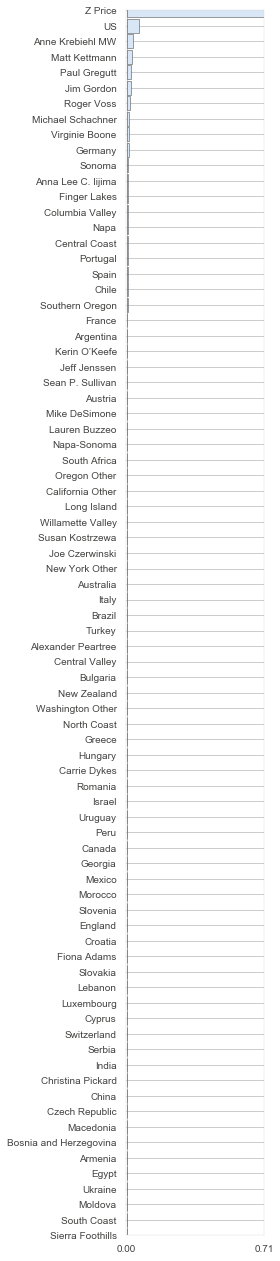

In [50]:
imp = importances(rf, X_test_encoded, y_test)
viz = plot_importances(imp)
viz.view()

In [51]:
imp.head(25)

,Importance
Feature,
Z Price,0.711412
US,0.064450
Anne Krebiehl MW,0.032086
Matt Kettmann,0.027494
Paul Gregutt,0.022437
Jim Gordon,0.020676
Roger Voss,0.018026
Michael Schachner,0.012959
Virginie Boone,0.012201


In [52]:
# tons of varieties
len(df.variety.value_counts())

707

In [53]:
df.variety.value_counts().head()

Pinot Noir                       13272
Chardonnay                       11753
Cabernet Sauvignon                9472
Red Blend                         8946
Bordeaux-style Red Blend          6915
Riesling                          5189
Sauvignon Blanc                   4967
Syrah                             4142
Rosé                              3564
Merlot                            3102
Nebbiolo                          2804
Zinfandel                         2714
Sangiovese                        2707
Malbec                            2652
Portuguese Red                    2466
White Blend                       2360
Sparkling Blend                   2153
Tempranillo                       1810
Rhône-style Red Blend             1471
Pinot Gris                        1455
Champagne Blend                   1396
Cabernet Franc                    1353
Grüner Veltliner                  1345
Portuguese White                  1159
Bordeaux-style White Blend        1066
Pinot Grigio             

In [54]:
hot_varieties = pd.get_dummies(df['variety'])

In [55]:
hot_varieties.corrwith(df['points']).abs().sort_values(ascending=False)

Pinot Noir                   0.106986
Rosé                         0.088433
Nebbiolo                     0.088123
Riesling                     0.067290
Sauvignon Blanc              0.066725
                               ...   
Merlot-Syrah                 0.000068
Duras                        0.000045
Pinot Bianco                 0.000010
Greco                        0.000009
Malbec-Cabernet Sauvignon    0.000008
Length: 707, dtype: float64

In [56]:
varieties_25 = hot_varieties.corrwith(df['points']).abs().sort_values(ascending=False).head(25).index
df.loc[~df.variety.isin(varieties_25), 'variety'] = 'Other'

In [57]:
countries_25 = hot_countries.corrwith(df['points']).abs().sort_values(ascending=False).head(15).index
df.loc[~df.country.isin(countries_25), 'country'] = np.nan

In [58]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,NaN,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Other,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Other,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [59]:
hot_varieties_25 = pd.get_dummies(df['variety']) 
hot_countries_25 = pd.get_dummies(df['country']) 

## Parsing Vintage Year

In [60]:
regex = re.compile('[^0-9]')
title_words = [t.split(' ') for t in df.title]  
rem_char_titles = []
for t in title_words:
    no_char_t = []
    for w in t:
        cw = regex.sub('',w)
        if len(cw) == 4:
            no_char_t.append(cw)
    rem_char_titles.append(no_char_t)

In [61]:
current_year = 2019

vintages = []
for i,l in enumerate(rem_char_titles):
    if not l:
        vintages.append(np.nan)
    elif len(l) == 1:
        year = int(l[0])
        if year >= 1900:
            vintages.append(year)
        else:
            vintages.append(1900)
    else:
        l = map(int,l)
        for i in l:
            if i > 1980 and i <= current_year:
                vintages.append(i)
                break
                
vintages = pd.Series(vintages)  

In [62]:
vintages

0         2013.0
1         2011.0
2         2013.0
3         2013.0
4         2012.0
           ...  
129966    2013.0
129967    2004.0
129968    2013.0
129969    2012.0
129970    2012.0
Length: 129971, dtype: float64

In [63]:
vintage_age = pd.DataFrame({'Age' : max(vintages) - vintages}).fillna(vintages.median())
vintage_age

,Age
0,4.0
1,6.0
2,4.0
3,4.0
4,5.0
...,...
129966,4.0
129967,13.0
129968,4.0
129969,5.0


## Creating Vintage Age Categoricals

In [64]:
vintage_age['Year 1'] = 0
vintage_age.loc[vintage_age['Age'] == 1, 'Year 1'] = 1

In [65]:
vintage_age['Year 3'] = 0
vintage_age.loc[(vintage_age['Age'] >= 3) & (vintage_age['Age'] < 5), 'Year 3'] = 1

In [66]:
vintage_age['Year 5'] = 0
vintage_age.loc[(vintage_age['Age'] >= 5) & (vintage_age['Age'] < 10), 'Year 5'] = 1

In [67]:
vintage_age['Year 10'] = 0
vintage_age.loc[(vintage_age['Age'] >= 10) & (vintage_age['Age'] < 15), 'Year 10'] = 1

In [68]:
vintage_age['Year 15'] = 0
vintage_age.loc[(vintage_age['Age'] >= 15) & (vintage_age['Age'] < 25), 'Year 15'] = 1

In [69]:
vintage_age['Year 25'] = 0
vintage_age.loc[(vintage_age['Age'] >= 25) & (vintage_age['Age'] < 30), 'Year 25'] = 1

In [73]:
vintage_age['Year Vintage'] = 0
vintage_age.loc[(vintage_age['Age'] >= 30), 'Year Vintage'] = 1

In [74]:
vintage_age

,Age,Year 1,Year 3,Year 5,Year 10,Year 15,Year 25,Year 30,Year 40,Year 50,Year Vintage
0,4.0,0,1,0,0,0,0,0,0,0,0
1,6.0,0,0,1,0,0,0,0,0,0,0
2,4.0,0,1,0,0,0,0,0,0,0,0
3,4.0,0,1,0,0,0,0,0,0,0,0
4,5.0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
129966,4.0,0,1,0,0,0,0,0,0,0,0
129967,13.0,0,0,0,1,0,0,0,0,0,0
129968,4.0,0,1,0,0,0,0,0,0,0,0
129969,5.0,0,0,1,0,0,0,0,0,0,0


## Outlier Removal

In [75]:
z_price.loc[z_price['Z Price'] > 5, 'Z Price'] = 5
z_price.loc[z_price['Z Price'] < -5, 'Z Price'] = -5

In [76]:
min(z_price['Z Price']), max(z_price['Z Price'])

(-0.7726377396161901, 5.0)

## Vader:  Sentiment Analysis

In [77]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,NaN,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Other,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Other,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [78]:
analyzer = SentimentIntensityAnalyzer()

In [79]:
compound_sent = df.description.apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [81]:
sentiment = pd.DataFrame({'Compound Sentiment': compound_sent})

## Description Parsing

In [82]:
adjectives =  ['fruit', 'strong', 'tangy', 'bitter', 'alcohol', 
               'floral', 'acidity', 'tobacco','tannin', 'ripe', 
               'spice', 'oak', 'rich', 'dry', 'crisp', 'sweet', 
               'vanilla', 'full', 'tropical', 'strong', 'bitter']

In [83]:
for adj in adjectives:
    df[adj] = 0
    df.loc[df.description.str.contains(adj), adj] = 1

In [84]:
adj_df = df[adjectives]
adj_df

,fruit,strong,tangy,bitter,alcohol,floral,acidity,tobacco,tannin,ripe,...,oak,rich,dry,crisp,sweet,vanilla,full,tropical,strong,bitter
0,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
129967,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
129968,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
129969,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [85]:
X_full_features = pd.concat([z_price, sentiment, vintage_age, hot_regions, hot_tasters, hot_countries_25, hot_varieties_25, adj_df], axis=1)
X_full_features

,Z Price,Compound Sentiment,Age,Year 1,Year 3,Year 5,Year 10,Year 15,Year 25,Year 30,...,oak,rich,dry,crisp,sweet,vanilla,full,tropical,strong,bitter
0,-0.243193,0.1531,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.495310,0.6486,6.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.520521,-0.1280,4.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-0.545733,0.3400,4.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.765272,0.8176,5.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,-0.167559,0.7331,4.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
129967,1.017388,0.5267,13.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
129968,-0.117135,0.1548,4.0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
129969,-0.066712,0.5267,5.0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
### ADD FEATURES

In [86]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full_features, y, test_size=0.20, random_state=42)

In [87]:
%%time
lr.fit(X_train_full, y_train)
y_pred_full_lr = lr.predict(X_test_full)
lr_results_full = evaluate(y_test, y_pred_full_lr)

CPU times: user 1.14 s, sys: 142 ms, total: 1.28 s
Wall time: 947 ms


In [88]:
lr_results_full

{'Median AE': 1.515,
 'MeanAE': 1.784,
 'R-Sq': 0.46,
 'MSE': 5.02,
 'Max Error': 11.73}

In [89]:
%%time
lasso.fit(X_train_full, y_train)
y_pred_full_lasso = lasso.predict(X_test_full)
lasso_results_full = evaluate(y_test, y_pred_full_lasso)

CPU times: user 278 ms, sys: 33.4 ms, total: 311 ms
Wall time: 219 ms


In [90]:
lasso_results_full

{'Median AE': 2.392,
 'MeanAE': 2.453,
 'R-Sq': 0.04,
 'MSE': 9.0,
 'Max Error': 11.33}

In [91]:
%%time
rf.fit(X_train_full, y_train)
y_pred_full_rf = rf.predict(X_test_full)
rf_results_full = evaluate(y_test, y_pred_full_rf)

CPU times: user 3min 51s, sys: 1.53 s, total: 3min 53s
Wall time: 1min 24s


In [92]:
rf_results_full

{'Median AE': 1.263,
 'MeanAE': 1.556,
 'R-Sq': 0.58,
 'MSE': 3.98,
 'Max Error': 10.18}

In [93]:
%%time
gbr.fit(X_train_full, y_train)
y_pred_full_gbr = gbr.predict(X_test_full)
gbr_results_full = evaluate(y_test, y_pred_full_gbr)

CPU times: user 50.3 s, sys: 579 ms, total: 50.9 s
Wall time: 35.9 s


In [94]:
gbr_results_full

{'Median AE': 1.392,
 'MeanAE': 1.662,
 'R-Sq': 0.53,
 'MSE': 4.39,
 'Max Error': 9.56}

# Results

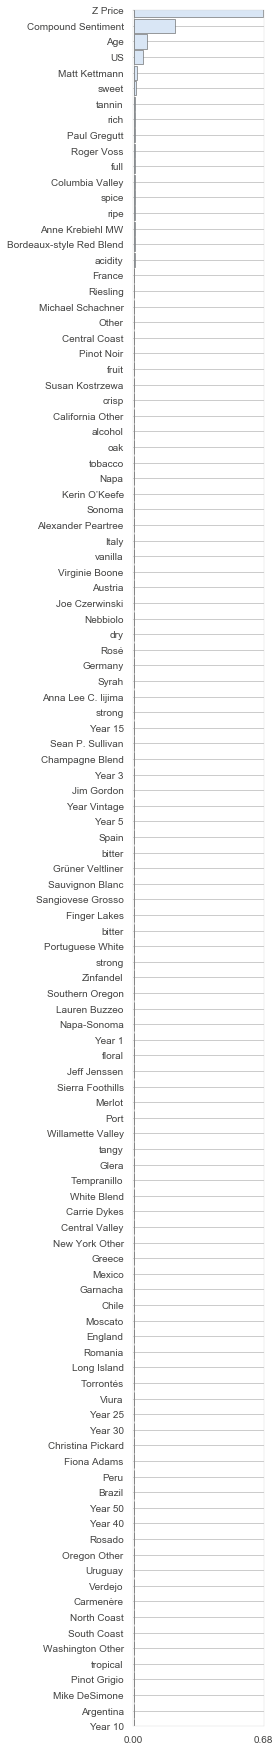

In [95]:
imp = importances(rf, X_test_full, y_test)
viz = plot_importances(imp)
viz.view()

In [97]:
imp.head(50)

,Importance
Feature,
Z Price,0.679801
Compound Sentiment,0.217102
Age,0.068012
US,0.051095
Matt Kettmann,0.019865
sweet,0.010826
tannin,0.009023
rich,0.008514
Paul Gregutt,0.008258


In [102]:
imp.tail(30)

,Importance
Feature,
Mexico,5.349592e-06
Garnacha,5.253585e-06
Chile,5.151899e-06
Moscato,4.784535e-06
England,3.297211e-06
Romania,1.861991e-06
Long Island,7.626441e-07
Torrontés,9.300773e-08
Viura,0.000000e+00


## Reduced Model

In [103]:
features_50 = imp.head(50).index

In [104]:
X_reduced = X_full_features[features_50]

In [105]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state=42)

In [106]:
%%time
rf.fit(X_train_reduced, y_train)
y_pred_reduced_rf = rf.predict(X_test_reduced)
rf_results_reduced = evaluate(y_test, y_pred_reduced_rf)

In [107]:
rf_results_reduced

{'Median AE': 1.271,
 'MeanAE': 1.562,
 'R-Sq': 0.57,
 'MSE': 4.0,
 'Max Error': 10.74}

In [108]:
hyperparameters = {"min_samples_leaf" : np.arange(5,100,5),
                    "n_estimators" : np.arange(10,200,20)}

In [109]:
random_cv = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, warm_start=True), 
                              hyperparameters, 
                              cv=3, 
                              n_iter=3, 
                              verbose=2)

In [ ]:
random_cv.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=90, min_samples_leaf=55 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. n_estimators=90, min_samples_leaf=55, total=  20.9s
[CV] n_estimators=90, min_samples_leaf=55 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV] ............. n_estimators=90, min_samples_leaf=55, total=  18.7s
[CV] n_estimators=90, min_samples_leaf=55 ............................
[CV] ............. n_estimators=90, min_samples_leaf=55, total=  19.9s
[CV] n_estimators=110, min_samples_leaf=70 ...........................
[CV] ............ n_estimators=110, min_samples_leaf=70, total=  25.4s
[CV] n_estimators=110, min_samples_leaf=70 ...........................
[CV] ............ n_estimators=110, min_samples_leaf=70, total=  24.4s
[CV] n_estimators=110, min_samples_leaf=70 ...........................
[CV] ............ n_estimators=110, min_samples_leaf=70, total=  25.0s
[CV] n_estimators=170, min_samples_leaf=35 ...........................


# Pipelines